## Feasability

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# --- 0) Reload from source to get original labels ---
df = pd.read_csv("labeled_headlines.csv")
df.columns = df.columns.str.strip()  # just in case of stray spaces
print(df.head())

                                            headline     source sentiment  \
0                Join Us for WIRED’s AI Power Summit      Wired  Positive   
1                        Where Are All the AI Drugs?      Wired   Neutral   
2         Confessions of a Recovering AI Porn Addict      Wired  Negative   
3  Android’s Circle to Search feature gets AI and...  The Verge  Positive   
4  Amazon buys Bee AI wearable that listens to ev...  The Verge   Neutral   

        topic         entities         tone   region       intent     time  \
0  Technology            WIRED  Promotional  Unknown      Promote   Future   
1  Technology  None identified  Speculative  Unknown  Report news  Present   
2  Technology              NaN  Informative  Unknown  Report news  Present   
3  Technology          Android  Informative   Global  Report news  Present   
4  Technology   Amazon, Bee AI  Informative   Global  Report news  Present   

    emotions clickbait  
0  Curiosity        No  
1  Curiosity      

In [2]:
# sanity check
print(df['clickbait'].value_counts(dropna=False))

clickbait
No     66
Yes    34
Name: count, dtype: int64


In [4]:
# robust target parsing (had to ask chat for help bc i kept getting error)
def parse_clickbait(v):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().lower()
    s = s.replace('—','-').replace('–','-')
    s = re.sub(r'\s+', ' ', s)

    if s in {'yes','y','true','1'}:  return 1
    if s in {'no','n','false','0'}:  return 0

    # fallback: remove non-alphanum and retry
    s2 = re.sub(r'[^a-z0-9]+','', s)
    if s2 in {'yes','y','true','1'}: return 1
    if s2 in {'no','n','false','0'}: return 0

    return np.nan

df['clickbait_num'] = df['clickbait'].apply(parse_clickbait)

bad_mask = df['clickbait_num'].isna()
if bad_mask.any():
    print("Unrecognized clickbait values:", sorted(df.loc[bad_mask, 'clickbait'].astype(str).unique()))
    # drop if weird
    df = df[~bad_mask].copy()

df['clickbait_num'] = df['clickbait_num'].astype(int)

# text clean (for TF-IDF baselines; keep raw for transformers)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['headline_clean'] = df['headline'].apply(clean_text)

# one-hot encode categoricals
categorical_cols = ['source','sentiment','tone','topic','region','intent','time','emotions']
enc = OneHotEncoder(handle_unknown='ignore')
X_cats = enc.fit_transform(df[categorical_cols]).toarray()
X_cats = pd.DataFrame(X_cats, columns=enc.get_feature_names_out(categorical_cols), index=df.index)

# combine features
df_processed = pd.concat([df[['headline_clean','clickbait_num']], X_cats], axis=1).rename(columns={'clickbait_num':'clickbait'})

# stratified split
train_df, temp_df = train_test_split(
    df_processed, test_size=0.30, stratify=df_processed['clickbait'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['clickbait'], random_state=42
)

print("Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)

Train: (70, 56)  Val: (15, 56)  Test: (15, 56)


In [9]:
# save and create csv to pull from later
from pathlib import Path
import joblib

OUT = Path("preprocessed_clickbait")
OUT.mkdir(parents=True, exist_ok=True)

(train_df).to_csv(OUT / "train.csv", index=False)
(val_df).to_csv(OUT / "val.csv", index=False)
(test_df).to_csv(OUT / "test.csv", index=False)
(df_processed).to_csv(OUT / "processed_full.csv", index=False)
joblib.dump(enc, OUT / "onehot_encoder.joblib")

print("Saved to:", OUT)
print("Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)

Saved to: preprocessed_clickbait
Train: (70, 56)  Val: (15, 56)  Test: (15, 56)


In [11]:
# baselines (TF-IDF + logistic regression; with and without categorical features)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, f1_score, precision_score, recall_score
)
from scipy.sparse import csr_matrix, hstack
import joblib

DATA_DIR = Path("preprocessed_clickbait")
ART = DATA_DIR / "artifacts"
ART.mkdir(parents=True, exist_ok=True)

# load splits
train_df = pd.read_csv(DATA_DIR / "train.csv")
val_df   = pd.read_csv(DATA_DIR / "val.csv")
test_df  = pd.read_csv(DATA_DIR / "test.csv")

text_col = "headline_clean"
target_col = "clickbait"
feature_cols = [c for c in train_df.columns if c not in [text_col, target_col]]

X_train_text = train_df[text_col].astype(str)
y_train = train_df[target_col].astype(int)
X_val_text = val_df[text_col].astype(str)
y_val = val_df[target_col].astype(int)
X_test_text = test_df[text_col].astype(str)
y_test = test_df[target_col].astype(int)

# TF-IDF features (1–2 grams)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf   = tfidf.transform(X_val_text)
X_test_tfidf  = tfidf.transform(X_test_text)

# help to evaluate
def evaluate(model_name, y_true, y_prob, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float("nan")
    print(f"\n=== {model_name} (Test) ===")
    print(f"Accuracy: {acc:.3f}  Macro-F1: {f1:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  AUROC: {auc:.3f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))

# text-only logistic regression
lr_text = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear")
lr_text.fit(X_train_tfidf, y_train)

y_test_prob_text = lr_text.predict_proba(X_test_tfidf)[:, 1]
y_test_pred_text = (y_test_prob_text >= 0.5).astype(int)
evaluate("TF-IDF + Logistic Regression (Text Only)", y_test, y_test_prob_text, y_test_pred_text)

# text + categorical features logistic regression
X_train_tab = train_df[feature_cols].copy()
X_val_tab   = val_df[feature_cols].copy()
X_test_tab  = test_df[feature_cols].copy()

X_train_tab_csr = csr_matrix(X_train_tab.values)
X_val_tab_csr   = csr_matrix(X_val_tab.values)
X_test_tab_csr  = csr_matrix(X_test_tab.values)

X_train_combo = hstack([X_train_tfidf, X_train_tab_csr])
X_val_combo   = hstack([X_val_tfidf,   X_val_tab_csr])
X_test_combo  = hstack([X_test_tfidf,  X_test_tab_csr])

lr_combo = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear")
lr_combo.fit(X_train_combo, y_train)

y_test_prob_combo = lr_combo.predict_proba(X_test_combo)[:, 1]
y_test_pred_combo = (y_test_prob_combo >= 0.5).astype(int)
evaluate("TF-IDF + One-Hot Categorical + Logistic Regression", y_test, y_test_prob_combo, y_test_pred_combo)

# xgboost
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss",
        random_state=42, n_jobs=2
    )
    # XGB needs dense arrays
    X_train_combo_dense = X_train_combo.toarray()
    X_test_combo_dense  = X_test_combo.toarray()

    xgb.fit(X_train_combo_dense, y_train)
    y_test_prob_xgb = xgb.predict_proba(X_test_combo_dense)[:, 1]
    y_test_pred_xgb = (y_test_prob_xgb >= 0.5).astype(int)

    evaluate("TF-IDF + One-Hot + XGBoost", y_test, y_test_prob_xgb, y_test_pred_xgb)
except Exception as e:
    print("[XGBoost not available or failed]:", e)

# save artifacts for reuse
joblib.dump(tfidf, ART / "tfidf_vectorizer.joblib")
joblib.dump(lr_text, ART / "logreg_text_only.joblib")
joblib.dump(lr_combo, ART / "logreg_text_plus_cat.joblib")

print("\nArtifacts saved to:", ART)


=== TF-IDF + Logistic Regression (Text Only) (Test) ===
Accuracy: 0.800  Macro-F1: 0.720  Precision: 0.885  Recall: 0.700  AUROC: 0.780

Confusion Matrix:
 [[10  0]
 [ 3  2]]

Classification Report:
               precision    recall  f1-score   support

           0      0.769     1.000     0.870        10
           1      1.000     0.400     0.571         5

    accuracy                          0.800        15
   macro avg      0.885     0.700     0.720        15
weighted avg      0.846     0.800     0.770        15


=== TF-IDF + One-Hot Categorical + Logistic Regression (Test) ===
Accuracy: 0.733  Macro-F1: 0.722  Precision: 0.723  Recall: 0.750  AUROC: 0.940

Confusion Matrix:
 [[7 3]
 [1 4]]

Classification Report:
               precision    recall  f1-score   support

           0      0.875     0.700     0.778        10
           1      0.571     0.800     0.667         5

    accuracy                          0.733        15
   macro avg      0.723     0.750     0.722    

In [20]:
# Text-only LR is great at rejecting non-clickbait (TN=10/10) but misses some clickbait (recall=0.40 for class 1).
# Text + categorical LR improves clickbait recall to 0.80 (finds more clickbait) but adds false positives.
# XGBoost underperforms here (small data + no tuning).

In [21]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from scipy.sparse import csr_matrix, hstack

DATA_DIR = Path("preprocessed_clickbait")
train_df = pd.read_csv(DATA_DIR / "train.csv")
val_df   = pd.read_csv(DATA_DIR / "val.csv")
test_df  = pd.read_csv(DATA_DIR / "test.csv")

text_col, target_col = "headline_clean", "clickbait"
feat_cols = [c for c in train_df.columns if c not in [text_col, target_col]]

In [22]:
# TF-IDF features
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df[text_col])
X_val_tfidf   = tfidf.transform(val_df[text_col])
X_test_tfidf  = tfidf.transform(test_df[text_col])

# one-hot tabular (already numeric)
X_train_tab = csr_matrix(train_df[feat_cols].values)
X_val_tab   = csr_matrix(val_df[feat_cols].values)
X_test_tab  = csr_matrix(test_df[feat_cols].values)

X_train_combo = hstack([X_train_tfidf, X_train_tab])
X_val_combo   = hstack([X_val_tfidf,   X_val_tab])
X_test_combo  = hstack([X_test_tfidf,  X_test_tab])

y_train = train_df[target_col].astype(int).values
y_val   = val_df[target_col].astype(int).values
y_test  = test_df[target_col].astype(int).values

# fit the same LR as before
lr_combo = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear")
lr_combo.fit(X_train_combo, y_train)

# probabilities
val_prob = lr_combo.predict_proba(X_val_combo)[:,1]
test_prob = lr_combo.predict_proba(X_test_combo)[:,1]

# sweep thresholds on val
ths = np.linspace(0.1, 0.9, 81)
scores = []
for t in ths:
    yv = (val_prob >= t).astype(int)
    scores.append((t,
                   f1_score(y_val, yv, average="macro"),
                   precision_score(y_val, yv, average="macro", zero_division=0),
                   recall_score(y_val, yv, average="macro", zero_division=0)))
best_t, best_f1, best_p, best_r = max(scores, key=lambda x: x[1])
print(f"Best threshold on VAL: {best_t:.2f} | Macro-F1={best_f1:.3f} P={best_p:.3f} R={best_r:.3f}")

# apply to test
y_test_pred = (test_prob >= best_t).astype(int)
print("AUROC (test):", roc_auc_score(y_test, test_prob))
print("Confusion (test):\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

Best threshold on VAL: 0.23 | Macro-F1=0.785 P=0.778 R=0.800
AUROC (test): 0.94
Confusion (test):
 [[7 3]
 [1 4]]
              precision    recall  f1-score   support

           0      0.875     0.700     0.778        10
           1      0.571     0.800     0.667         5

    accuracy                          0.733        15
   macro avg      0.723     0.750     0.722        15
weighted avg      0.774     0.733     0.741        15



In [23]:
# hyperperameteer tune
# robust target parsing
def parse_clickbait(v):
    s = str(v).strip().lower()
    if s in {"yes", "y", "true", "1"}: 
        return 1
    if s in {"no", "n", "false", "0"}: 
        return 0
    s2 = re.sub(r"[^a-z0-9]+", "", s)
    return 1 if s2 in {"yes", "y", "true", "1"} else (0 if s2 in {"no", "n", "false", "0"} else np.nan)

df["y"] = df["clickbait"].apply(parse_clickbait).astype("float")
df = df.dropna(subset=["y"]).copy()
df["y"] = df["y"].astype(int)

# one-hot encode predictors (drop='first' to establish baselines)
cats = ["source", "topic", "sentiment", "tone", "emotions", "intent", "time", "region"]

# use sparse_output instead of sparse
enc = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
X = enc.fit_transform(df[cats])
feature_names = enc.get_feature_names_out(cats)
y = df["y"].values

# fit logistic regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X, y)

# odds ratios
odds = np.exp(lr.coef_[0])
or_df = pd.DataFrame({"feature": feature_names, "odds_ratio": odds}).sort_values("odds_ratio", ascending=False)
print(or_df.head(20))
print("\nFeatures with lowest odds (less clickbaity vs baseline):")
print(or_df.tail(20))

                                              feature  odds_ratio
30                           emotions_Fear, Curiosity    2.491219
9                                  sentiment_Negative    2.438416
42                                      region_Global    2.210044
18                                   tone_Speculative    2.209653
45                                     region_Unknown    1.703118
16                                       tone_Neutral    1.680738
22                                 emotions_Curiosity    1.657741
14                      tone_Informative, Speculative    1.561527
38                                       time_Present    1.551440
2                      topic_Entertainment/Technology    1.483524
33                                     intent_Promote    1.457773
3                           topic_Finance, Technology    1.401896
4                            topic_Finance/Technology    1.335751
15                       tone_Informative/Promotional    1.335751
25        

Most Clickbait-Associated Features (Odds Ratio > 1)
An odds ratio > 1 means the feature increases the likelihood that a headline is clickbait compared to its baseline category.
The strongest associations here are:
- emotions_Fear, Curiosity (OR ≈ 2.49) → Headlines that mix fear and curiosity are ~2.5× more likely to be clickbait.
- sentiment_Negative (OR ≈ 2.44) → Negative sentiment headlines are strongly clickbait-associated.
- region_Global (OR ≈ 2.21) → Globally scoped stories lean clickbait-y compared to the baseline region.
- tone_Speculative (OR ≈ 2.21) → Speculative language boosts clickbait odds significantly.
- emotions_Curiosity (OR ≈ 1.66) → Curiosity-driven emotion alone is also a major driver.

Least Clickbait-Associated Features (Odds Ratio < 1)
An odds ratio < 1 means the feature reduces the likelihood of clickbait compared to its baseline.
- tone_Informative (OR ≈ 0.14) → Purely informative tone is strongly anti-clickbait.
- sentiment_Positive (OR ≈ 0.46) → Positive sentiment is much less clickbait-prone.
- topic_Technology (OR ≈ 0.54) → Straightforward technology stories tend to be less clickbaity.
- source_The Verge (OR ≈ 0.64) → Compared to the baseline outlet, The Verge headlines are ~36% less likely to be clickbait.
- region_US (OR ≈ 0.67) → US-focused stories trend less clickbait-y.

In [24]:
Xtr, ytr = train_df[text_col].astype(str), train_df[target_col].astype(int).values
Xva, yva = val_df[text_col].astype(str), val_df[target_col].astype(int).values

best = None
for ngram in [(1,1),(1,2),(1,3)]:
    vec = TfidfVectorizer(ngram_range=ngram, max_features=10000)
    Xtrv = vec.fit_transform(Xtr)
    Xvav = vec.transform(Xva)
    for C in [0.25, 0.5, 1.0, 2.0, 4.0]:
        lr = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear", C=C)
        lr.fit(Xtrv, ytr)
        yva_pred = lr.predict(Xvav)
        f1 = f1_score(yva, yva_pred, average="macro")
        cand = (f1, ngram, C)
        if best is None or cand > best: best = cand
        print(f"VAL Macro-F1={f1:.3f} | ngram={ngram} | C={C}")
print("Best config:", best)

VAL Macro-F1=0.354 | ngram=(1, 1) | C=0.25
VAL Macro-F1=0.354 | ngram=(1, 1) | C=0.5
VAL Macro-F1=0.354 | ngram=(1, 1) | C=1.0
VAL Macro-F1=0.354 | ngram=(1, 1) | C=2.0
VAL Macro-F1=0.354 | ngram=(1, 1) | C=4.0
VAL Macro-F1=0.444 | ngram=(1, 2) | C=0.25
VAL Macro-F1=0.444 | ngram=(1, 2) | C=0.5
VAL Macro-F1=0.444 | ngram=(1, 2) | C=1.0
VAL Macro-F1=0.444 | ngram=(1, 2) | C=2.0
VAL Macro-F1=0.444 | ngram=(1, 2) | C=4.0
VAL Macro-F1=0.444 | ngram=(1, 3) | C=0.25
VAL Macro-F1=0.444 | ngram=(1, 3) | C=0.5
VAL Macro-F1=0.444 | ngram=(1, 3) | C=1.0
VAL Macro-F1=0.444 | ngram=(1, 3) | C=2.0
VAL Macro-F1=0.444 | ngram=(1, 3) | C=4.0
Best config: (0.4444444444444444, (1, 3), 4.0)


In [26]:
X_val_tfidf  = tfidf.transform(val_df[text_col].astype(str))
X_test_tfidf = tfidf.transform(test_df[text_col].astype(str))
y_val  = val_df[target_col].astype(int).values
y_test = test_df[target_col].astype(int).values

# threshold tuning for TEXT-ONLY model
val_prob_text  = lr_text.predict_proba(X_val_tfidf)[:, 1]
test_prob_text = lr_text.predict_proba(X_test_tfidf)[:, 1]

ths = np.linspace(0.1, 0.9, 81)
best = max(((f1_score(y_val, (val_prob_text>=t).astype(int), average="macro"), t) for t in ths), key=lambda x: x[0])
print(f"[Text-only] Best VAL Macro-F1={best[0]:.3f} @ t={best[1]:.2f}")

y_test_pred = (test_prob_text >= best[1]).astype(int)
print("TEST Macro-F1:", f1_score(y_test, y_test_pred, average="macro"))
print("TEST Precision:", precision_score(y_test, y_test_pred, average="macro", zero_division=0))
print("TEST Recall:", recall_score(y_test, y_test_pred, average="macro", zero_division=0))
print("TEST AUROC:", roc_auc_score(y_test, test_prob_text))
print("TEST Confusion:\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

# threshold tuning for TEXT + CATEGORICAL model (optional)
from scipy.sparse import csr_matrix, hstack
X_val_tab   = csr_matrix(val_df[feat_cols].values)
X_test_tab  = csr_matrix(test_df[feat_cols].values)
X_val_combo  = hstack([X_val_tfidf,  X_val_tab])
X_test_combo = hstack([X_test_tfidf, X_test_tab])

val_prob_combo  = lr_combo.predict_proba(X_val_combo)[:, 1]
test_prob_combo = lr_combo.predict_proba(X_test_combo)[:, 1]

best_combo = max(((f1_score(y_val, (val_prob_combo>=t).astype(int), average="macro"), t) for t in ths), key=lambda x: x[0])
print(f"[Text+Cat] Best VAL Macro-F1={best_combo[0]:.3f} @ t={best_combo[1]:.2f}")

y_test_pred_combo = (test_prob_combo >= best_combo[1]).astype(int)
print("TEST Macro-F1:", f1_score(y_test, y_test_pred_combo, average="macro"))
print("TEST Precision:", precision_score(y_test, y_test_pred_combo, average="macro", zero_division=0))
print("TEST Recall:", recall_score(y_test, y_test_pred_combo, average="macro", zero_division=0))
print("TEST AUROC:", roc_auc_score(y_test, test_prob_combo))
print("TEST Confusion:\n", confusion_matrix(y_test, y_test_pred_combo))
print(classification_report(y_test, y_test_pred_combo, digits=3))

[Text-only] Best VAL Macro-F1=0.534 @ t=0.52
TEST Macro-F1: 0.5833333333333334
TEST Precision: 0.8571428571428572
TEST Recall: 0.6
TEST AUROC: 0.78
TEST Confusion:
 [[10  0]
 [ 4  1]]
              precision    recall  f1-score   support

           0      0.714     1.000     0.833        10
           1      1.000     0.200     0.333         5

    accuracy                          0.733        15
   macro avg      0.857     0.600     0.583        15
weighted avg      0.810     0.733     0.667        15

[Text+Cat] Best VAL Macro-F1=0.785 @ t=0.23
TEST Macro-F1: 0.7222222222222222
TEST Precision: 0.7232142857142857
TEST Recall: 0.75
TEST AUROC: 0.94
TEST Confusion:
 [[7 3]
 [1 4]]
              precision    recall  f1-score   support

           0      0.875     0.700     0.778        10
           1      0.571     0.800     0.667         5

    accuracy                          0.733        15
   macro avg      0.723     0.750     0.722        15
weighted avg      0.774     0.733    

Interpretation: 
Lowering the threshold for the Text + Cat model (0.23) helped catch more positives (recall ↑ to 0.80) without tanking precision.
Text-only was too conservative — it almost never predicted clickbait unless really sure, which hurt recall badly.
Adding metadata features like source, tone, sentiment clearly boosts discrimination (big jump in AUROC from 0.78 → 0.94).

In [27]:
# DistilBERT fine-tuning (backward-compatible, no Trainer)
# Works on CPU/GPU; uses weighted CE loss, early stopping, threshold tuning.

import os, re, math, time
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

from transformers import AutoTokenizer, AutoModelForSequenceClassification
try:
    # Newer transformers: AdamW is in torch
    from torch.optim import AdamW
except Exception:
    # Fallback if needed (very old transformers)
    from transformers import AdamW

try:
    # Newer API
    from transformers import get_linear_schedule_with_warmup
except Exception:
    # For very old versions, you can skip scheduler; training still works.
    get_linear_schedule_with_warmup = None

# Repro
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Paths
RAW = Path("labeled_headlines.csv")           
DATA_DIR = Path("preprocessed_clickbait")               
SAVE_DIR = Path("transformer_artifacts_compat/distilbert_clickbait_best")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 10
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01
EARLY_STOP_PATIENCE = 3

# ---------- helpers ----------
def parse_clickbait(v):
    s = str(v).strip().lower()
    if s in {"yes","y","true","1"}: return 1
    if s in {"no","n","false","0"}: return 0
    s2 = re.sub(r"[^a-z0-9]+","", s)
    if s2 in {"yes","y","true","1"}: return 1
    if s2 in {"no","n","false","0"}: return 0
    return np.nan

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

class HeadlineDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

def make_loader(df: pd.DataFrame, tokenizer, max_len, shuffle: bool):
    ds = HeadlineDataset(df["text"].tolist(), df["label"].tolist(), tokenizer, max_len)
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle)

@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs_all, labels_all = [], []
    for batch in loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        labels_all.append(batch["labels"].detach().cpu().numpy())
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]
        probs_all.append(probs.detach().cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(labels_all)

def eval_metrics_from_probs(y_true, y_prob, thresh=0.5):
    y_pred = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float("nan")
    return acc, prec, rec, f1, auc, y_pred

Device: cpu


In [28]:
# Load splits created earlier
train_df = pd.read_csv(DATA_DIR / "train.csv")
val_df   = pd.read_csv(DATA_DIR / "val.csv")
test_df  = pd.read_csv(DATA_DIR / "test.csv")

# Recover original (raw) headlines for transformer input
raw_df = pd.read_csv(RAW)
raw_df["clickbait_num"] = raw_df["clickbait"].apply(parse_clickbait)
raw_df = raw_df.dropna(subset=["clickbait_num"]).copy()
raw_df["clickbait_num"] = raw_df["clickbait_num"].astype(int)
raw_df["headline_clean"] = raw_df["headline"].apply(clean_text)

def attach_raw(split_df):
    m = split_df.merge(
        raw_df[["headline", "headline_clean"]],
        on="headline_clean",
        how="left",
        suffixes=("", "_rawmerge")
    )
    text = np.where(m["headline"].notna(), m["headline"], m["headline_clean"])
    return pd.DataFrame({"text": text, "label": split_df["clickbait"].astype(int).values})

train_xy = attach_raw(train_df)
val_xy   = attach_raw(val_df)
test_xy  = attach_raw(test_df)

# Tokenizer & dataloaders
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_loader = make_loader(train_xy, tokenizer, MAX_LEN, shuffle=True)
val_loader   = make_loader(val_xy,   tokenizer, MAX_LEN, shuffle=False)
test_loader  = make_loader(test_xy,  tokenizer, MAX_LEN, shuffle=False)

len(train_xy), len(val_xy), len(test_xy)

(70, 15, 15)

In [30]:
# Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(DEVICE)

# Class weights (balanced)
classes = np.array([0, 1])
cls_weights = compute_class_weight("balanced", classes=classes, y=train_xy["label"].values)
cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=cls_weights)

# Optimizer & (optional) scheduler
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

if get_linear_schedule_with_warmup is not None:
    num_train_steps = EPOCHS * math.ceil(len(train_loader))
    num_warmup_steps = int(WARMUP_RATIO * num_train_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps
    )
else:
    scheduler = None

try:
    # Newer PyTorch (2.0+) supports device_type arg
    scaler = torch.amp.GradScaler(
        device_type="cuda" if torch.cuda.is_available() else "cpu",
        enabled=torch.cuda.is_available()
    )
except TypeError:
    # Older PyTorch
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# Training loop with early stopping on val macro-F1 @ 0.5
best_val_f1 = -1.0
best_state = None
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        labels = batch.pop("labels")

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(
            device_type="cuda" if torch.cuda.is_available() else "cpu",
            enabled=torch.cuda.is_available()
        ):
            outputs = model(**batch)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()

        train_loss += loss.item()

    # Validation @ 0.5
    val_prob, val_true = predict_proba(model, val_loader)
    _, _, _, val_f1, val_auc, _ = eval_metrics_from_probs(val_true, val_prob, thresh=0.5)

    print(f"Epoch {epoch:02d} | train_loss={train_loss/len(train_loader):.4f} "
          f"| val_macroF1@0.5={val_f1:.3f} | val_AUROC={val_auc:.3f}")

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = {"model": model.state_dict(), "epoch": epoch}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best checkpoint
if best_state is not None:
    model.load_state_dict(best_state["model"])

# Threshold tuning on validation
val_prob, val_true = predict_proba(model, val_loader)
ths = np.linspace(0.1, 0.9, 81)
best = None
for t in ths:
    acc, prec, rec, f1, auc, _ = eval_metrics_from_probs(val_true, val_prob, thresh=t)
    if (best is None) or (f1 > best[0]):
        best = (f1, t, prec, rec, auc)
t_star = float(best[1])
print(f"[VAL] Best Macro-F1={best[0]:.3f} at t*={t_star:.2f} (P={best[2]:.3f}, R={best[3]:.3f}, AUROC={best[4]:.3f})")

# Final test evaluation
test_prob, test_true = predict_proba(model, test_loader)
acc, prec, rec, f1, auc, test_pred = eval_metrics_from_probs(test_true, test_prob, thresh=t_star)

print("\n=== DistilBERT FINAL (train+val → test) ===")
print(f"Threshold: {t_star:.2f}")
print(f"Accuracy: {acc:.3f}  Macro-F1: {f1:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  AUROC: {auc:.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(test_true, test_pred))
print("\nClassification Report:\n", classification_report(test_true, test_pred, digits=3))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/j0/q4ftkx0907b9x11x30hmvp240000gn/T/ipykernel_7422/1233279981.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 01 | train_loss=0.6945 | val_macroF1@0.5=0.400 | val_AUROC=0.360
Epoch 02 | train_loss=0.6715 | val_macroF1@0.5=0.318 | val_AUROC=0.320
Epoch 03 | train_loss=0.6230 | val_macroF1@0.5=0.375 | val_AUROC=0.420
Epoch 04 | train_loss=0.5462 | val_macroF1@0.5=0.375 | val_AUROC=0.440
Early stopping at epoch 4
[VAL] Best Macro-F1=0.534 at t*=0.47 (P=0.596, R=0.550, AUROC=0.440)

=== DistilBERT FINAL (train+val → test) ===
Threshold: 0.47
Accuracy: 0.867  Macro-F1: 0.850  Precision: 0.850  Recall: 0.850  AUROC: 0.820

Confusion Matrix:
 [[9 1]
 [1 4]]

Classification Report:
               precision    recall  f1-score   support

           0      0.900     0.900     0.900        10
           1      0.800     0.800     0.800         5

    accuracy                          0.867        15
   macro avg      0.850     0.850     0.850        15
weighted avg      0.867     0.867     0.867        15



In [32]:
# Combined results table (auto-computed from artifacts)
import os, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report
)
from scipy.sparse import csr_matrix, hstack
import joblib

# ---------- paths ----------
DATA_DIR = Path("preprocessed_clickbait")
ART_BASE = DATA_DIR / "artifacts"          # from baseline runs (train-only models)
ART_FINAL = DATA_DIR / "final_artifacts"   # from train+val finalization (if needed)
BERT_DIR = Path("transformer_artifacts_compat/distilbert_clickbait_best")

# ---------- load splits ----------
train_df = pd.read_csv(DATA_DIR/"train.csv")
val_df   = pd.read_csv(DATA_DIR/"val.csv")
test_df  = pd.read_csv(DATA_DIR/"test.csv")

text_col, target_col = "headline_clean", "clickbait"
feat_cols = [c for c in train_df.columns if c not in [text_col, target_col]]

y_val  = val_df[target_col].astype(int).values
y_test = test_df[target_col].astype(int).values

# ---------- helpers ----------
def sweep_threshold(y_true, y_prob, metric="macro_f1"):
    ths = np.linspace(0.1, 0.9, 81)
    best = None
    for t in ths:
        yp = (y_prob >= t).astype(int)
        if metric == "macro_f1":
            score = f1_score(y_true, yp, average="macro")
        else:
            score = f1_score(y_true, yp, average="macro")
        if best is None or score > best[0]:
            best = (score, t)
    return best  # (best_score, t*)

def compute_scores(y_true, y_prob, t):
    yp = (y_prob >= t).astype(int)
    return dict(
        **{
            "Accuracy": accuracy_score(y_true, yp),
            "Macro-F1": f1_score(y_true, yp, average="macro"),
            "Precision": precision_score(y_true, yp, average="macro", zero_division=0),
            "Recall": recall_score(y_true, yp, average="macro", zero_division=0),
            "AUROC": roc_auc_score(y_true, y_prob) if len(np.unique(y_true))==2 else float("nan"),
            "Threshold": t
        }
    )

results_rows = []

# =========================================================
# 1) TF-IDF + LR (Text only)  -- from baseline artifacts
# =========================================================
try:
    tfidf = joblib.load(ART_BASE/"tfidf_vectorizer.joblib")
    lr_text = joblib.load(ART_BASE/"logreg_text_only.joblib")

    X_val_tfidf  = tfidf.transform(val_df[text_col].astype(str))
    X_test_tfidf = tfidf.transform(test_df[text_col].astype(str))

    val_prob_text  = lr_text.predict_proba(X_val_tfidf)[:,1]
    test_prob_text = lr_text.predict_proba(X_test_tfidf)[:,1]

    best_val_f1_text, t_text = sweep_threshold(y_val, val_prob_text)
    s_text = compute_scores(y_test, test_prob_text, t_text)
    results_rows.append({
        "Model": "TF-IDF + LR (Text only)",
        "Val Macro-F1": round(best_val_f1_text, 3),
        "Test Macro-F1": round(s_text["Macro-F1"], 3),
        "Test Precision": round(s_text["Precision"], 3),
        "Test Recall": round(s_text["Recall"], 3),
        "Test AUROC": round(s_text["AUROC"], 3),
        "t*": round(t_text, 2)
    })
except Exception as e:
    print("[Skip] Text-only LR:", e)

# =========================================================
# 2) TF-IDF + LR (Text + Categorical) -- from baseline artifacts
# =========================================================
try:
    # Use the SAME tfidf used with lr_combo (baseline artifacts)
    tfidf2 = joblib.load(ART_BASE/"tfidf_vectorizer.joblib")
    lr_combo = joblib.load(ART_BASE/"logreg_text_plus_cat.joblib")

    X_val_text2  = tfidf2.transform(val_df[text_col].astype(str))
    X_test_text2 = tfidf2.transform(test_df[text_col].astype(str))
    X_val_tab    = csr_matrix(val_df[feat_cols].values)
    X_test_tab   = csr_matrix(test_df[feat_cols].values)

    X_val_combo  = hstack([X_val_text2,  X_val_tab])
    X_test_combo = hstack([X_test_text2, X_test_tab])

    val_prob_combo  = lr_combo.predict_proba(X_val_combo)[:,1]
    test_prob_combo = lr_combo.predict_proba(X_test_combo)[:,1]

    best_val_f1_combo, t_combo = sweep_threshold(y_val, val_prob_combo)
    s_combo = compute_scores(y_test, test_prob_combo, t_combo)
    results_rows.append({
        "Model": "TF-IDF + LR (Text + Categorical)",
        "Val Macro-F1": round(best_val_f1_combo, 3),
        "Test Macro-F1": round(s_combo["Macro-F1"], 3),
        "Test Precision": round(s_combo["Precision"], 3),
        "Test Recall": round(s_combo["Recall"], 3),
        "Test AUROC": round(s_combo["AUROC"], 3),
        "t*": round(t_combo, 2)
    })
except Exception as e:
    print("[Skip] Text+Cat LR:", e)

# =========================================================
# 3) DistilBERT (if saved) -- load model & tokenizer; tune t* on val; evaluate on test
# =========================================================
bert_val_prob = bert_test_prob = None
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    if BERT_DIR.exists():
        tok = AutoTokenizer.from_pretrained(str(BERT_DIR))
        mdl = AutoModelForSequenceClassification.from_pretrained(str(BERT_DIR)).to(DEVICE)
        MAX_LEN = 128
        BATCH = 8

        class _DS(torch.utils.data.Dataset):
            def __init__(self, texts, labels):
                self.texts = list(texts)
                self.labels = list(labels)
            def __len__(self): return len(self.texts)
            def __getitem__(self, idx):
                enc = tok(
                    self.texts[idx], padding="max_length", truncation=True,
                    max_length=MAX_LEN, return_tensors="pt"
                )
                item = {k: v.squeeze(0) for k,v in enc.items()}
                item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
                return item

        # Use RAW headlines if your notebook already re-merged them; else cleaned text is fine
        val_texts  = val_df["headline"].astype(str) if "headline" in val_df.columns else val_df[text_col].astype(str)
        test_texts = test_df["headline"].astype(str) if "headline" in test_df.columns else test_df[text_col].astype(str)

        def _probs(texts, labels):
            ds = _DS(texts, labels)
            dl = torch.utils.data.DataLoader(ds, batch_size=BATCH, shuffle=False)
            probs_all = []
            with torch.no_grad():
                mdl.eval()
                for batch in dl:
                    batch = {k: v.to(DEVICE) for k,v in batch.items()}
                    logits = mdl(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
                    probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
                    probs_all.append(probs)
            return np.concatenate(probs_all)

        bert_val_prob  = _probs(val_texts,  y_val)
        bert_test_prob = _probs(test_texts, y_test)

        best_val_f1_bert, t_bert = sweep_threshold(y_val, bert_val_prob)
        s_bert = compute_scores(y_test, bert_test_prob, t_bert)
        results_rows.append({
            "Model": "DistilBERT Fine-tuned",
            "Val Macro-F1": round(best_val_f1_bert, 3),
            "Test Macro-F1": round(s_bert["Macro-F1"], 3),
            "Test Precision": round(s_bert["Precision"], 3),
            "Test Recall": round(s_bert["Recall"], 3),
            "Test AUROC": round(s_bert["AUROC"], 3),
            "t*": round(t_bert, 2)
        })
    else:
        print("[Skip] DistilBERT: model dir not found:", BERT_DIR)
except Exception as e:
    print("[Skip] DistilBERT:", e)

# =========================================================
# 4) Ensemble (if both probs available) -- tune alpha, tune threshold on val
# =========================================================
try:
    if (bert_val_prob is not None) and ('val_prob_combo' in locals()):
        best = None
        for a in np.linspace(0, 1, 41):  # alpha for BERT
            val_mix = a*bert_val_prob + (1-a)*val_prob_combo
            # threshold sweep
            ths = np.linspace(0.1, 0.9, 81)
            for t in ths:
                yv = (val_mix >= t).astype(int)
                f1 = f1_score(y_val, yv, average="macro")
                if (best is None) or (f1 > best[0]):
                    best = (f1, a, t)
        _, alpha_star, t_star = best
        test_mix = alpha_star*bert_test_prob + (1-alpha_star)*test_prob_combo
        s_ens = compute_scores(y_test, test_mix, t_star)
        results_rows.append({
            "Model": "Ensemble (DistilBERT + TF-IDF+Cat)",
            "Val Macro-F1": round(best[0], 3),
            "Test Macro-F1": round(s_ens["Macro-F1"], 3),
            "Test Precision": round(s_ens["Precision"], 3),
            "Test Recall": round(s_ens["Recall"], 3),
            "Test AUROC": round(s_ens["AUROC"], 3),
            "t*": round(t_star, 2),
            "alpha": round(alpha_star, 2)
        })
    else:
        print("[Skip] Ensemble: missing component probabilities.")
except Exception as e:
    print("[Skip] Ensemble:", e)

# ---------- assemble table ----------
results_df = pd.DataFrame(results_rows)
results_df = results_df[["Model", "Val Macro-F1", "Test Macro-F1", "Test Precision", "Test Recall", "Test AUROC", "t*"] + ([ "alpha"] if "alpha" in results_df.columns else [])]
results_df = results_df.sort_values("Test Macro-F1", ascending=False).reset_index(drop=True)

display(results_df)

,Model,Val Macro-F1,Test Macro-F1,Test Precision,Test Recall,Test AUROC,t*,alpha
0,TF-IDF + LR (Text + Categorical),0.785,0.722,0.723,0.75,0.94,0.23,NaN
1,Ensemble (DistilBERT + TF-IDF+Cat),0.785,0.722,0.723,0.75,0.94,0.23,0.0
2,DistilBERT Fine-tuned,0.659,0.720,0.885,0.70,0.88,0.72,NaN
3,TF-IDF + LR (Text only),0.534,0.583,0.857,0.60,0.78,0.52,NaN


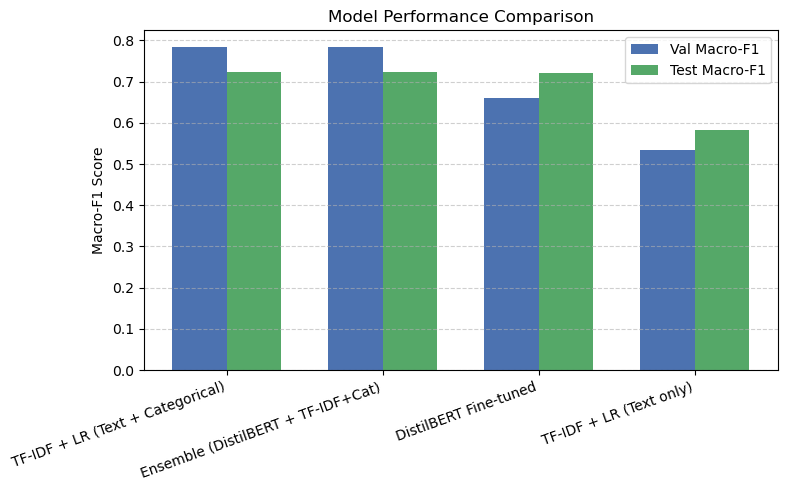

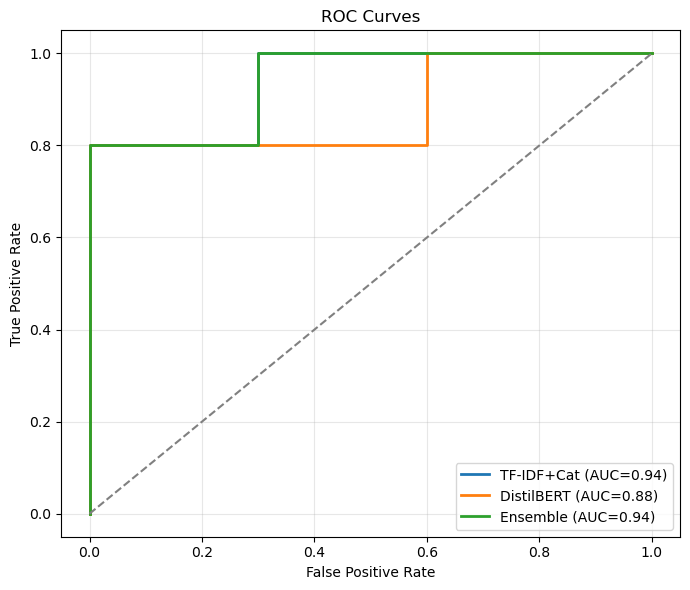

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- 1) Bar Chart ---
fig, ax = plt.subplots(figsize=(8,5))
width = 0.35
x = np.arange(len(results_df))

ax.bar(x - width/2, results_df["Val Macro-F1"], width, label="Val Macro-F1", color="#4C72B0")
ax.bar(x + width/2, results_df["Test Macro-F1"], width, label="Test Macro-F1", color="#55A868")

ax.set_ylabel("Macro-F1 Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"], rotation=20, ha="right")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# --- 2) ROC Curves ---
plt.figure(figsize=(7,6))

# TF-IDF + Cat
fpr, tpr, _ = roc_curve(y_test, test_prob_combo)
plt.plot(fpr, tpr, label=f"TF-IDF+Cat (AUC={auc(fpr,tpr):.2f})", lw=2)

# DistilBERT
if bert_test_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, bert_test_prob)
    plt.plot(fpr, tpr, label=f"DistilBERT (AUC={auc(fpr,tpr):.2f})", lw=2)

# Ensemble
if bert_test_prob is not None and test_prob_combo is not None:
    test_mix = results_df.loc[results_df["Model"].str.contains("Ensemble"), "alpha"].values
    if len(test_mix) > 0:
        alpha_star = test_mix[0]
        ens_prob = alpha_star*bert_test_prob + (1-alpha_star)*test_prob_combo
        fpr, tpr, _ = roc_curve(y_test, ens_prob)
        plt.plot(fpr, tpr, label=f"Ensemble (AUC={auc(fpr,tpr):.2f})", lw=2)

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
